In [12]:
#install library
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
import keras.backend as K
from datetime import datetime

from matplotlib import pyplot
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
#loading the data and check if there is missing value
data_btc = pd.read_csv('btc python.csv')
data_btc = data_btc.fillna(method='ffill')
data_btc.isnull().values.any()
#no missing value
data_btc.head()

,Date,btc_price,Open,High,Low,btc_change
0,1/2/2013,13.28,13.28,13.28,13.28,-0.0015
1,1/3/2013,13.40,13.4,13.4,13.4,0.0090
2,1/4/2013,13.50,13.5,13.5,13.5,0.0075
3,1/5/2013,13.44,13.44,13.44,13.44,-0.0044
4,1/6/2013,13.45,13.45,13.45,13.45,0.0007


In [3]:
data_vix = pd.read_csv("vix python.csv")
data_vix = data_vix.fillna(method='ffill')
data_vix.isnull().values.any()
data_vix.head()
#no missing value

,Date,vix_price,Open,High,Low,vix_change
0,1/2/2013,14.68,15.24,15.93,14.60,-0.1853
1,1/3/2013,14.56,14.77,14.92,14.24,-0.0082
2,1/4/2013,13.83,14.23,14.31,13.64,-0.0501
3,1/5/2013,13.83,14.23,14.31,13.64,-0.0501
4,1/6/2013,13.83,14.23,14.31,13.64,-0.0501


In [4]:
data_em = pd.read_csv("MSCI EM.csv")
data_em = data_em.fillna(method='ffill')
data_em.isnull().values.any()
data_em.head()
#no missing value

,Date,em_price,Open,High,Low,em_change
0,1/2/2013,1831.84,"1,865.66","1,865.71","1,830.84",-2.13%
1,1/3/2013,1824.08,"1,831.57","1,834.27","1,822.82",-0.42%
2,1/4/2013,1832.08,"1,827.59","1,837.61","1,827.58",0.44%
3,1/5/2013,1832.08,"1,827.59","1,837.61","1,827.58",0.44%
4,1/6/2013,1832.08,"1,827.59","1,837.61","1,827.58",0.44%


In [5]:
from pandas import Series, DataFrame

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

#see btc data in usual datetime format
data_btc['date'] = pd.to_datetime(data_btc['Date'], format="%m/%d/%Y").dt.date
group = data_btc.groupby('date')
Daily_Price_btc = group['btc_price'].mean()
Daily_Price_btc.head()

#see vix data in usual datetime format
data_vix['date'] = pd.to_datetime(data_vix['Date'], format="%m/%d/%Y").dt.date
group = data_vix.groupby('date')
Daily_Price_vix = group['vix_price'].mean()
Daily_Price_vix.head()

#see em data in usual datetime format
data_em['date'] = pd.to_datetime(data_em['Date'], format="%m/%d/%Y").dt.date
group = data_em.groupby('date')
Daily_Price_em = group['em_price'].mean()
Daily_Price_em.head()

#check the length of the two time series
print(len(Daily_Price_btc))
print(len(Daily_Price_vix))

#combine two time series together
Daily_Price = pd.concat([Daily_Price_btc, Daily_Price_vix, Daily_Price_em], axis=1)
print(Daily_Price.head())

from datetime import date

d0 = date(2016, 1, 2)
d1 = date(2018, 5, 20)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = date(2018, 2, 1)
d1 = date(2018, 5, 24)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2018, 5, 21)
d1 = date(2018, 5, 24)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

1969
1969
            btc_price  vix_price  em_price
date                                      
2013-01-02      13.28      14.68   1831.84
2013-01-03      13.40      14.56   1824.08
2013-01-04      13.50      13.83   1832.08
2013-01-05      13.44      13.83   1832.08
2013-01-06      13.45      13.83   1832.08
870
113
4


In [6]:
#daily bitcoin price
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))
print(df_train.head())

761 113
            btc_price  vix_price  em_price
date                                      
2016-01-02     432.70      18.21   2103.62
2016-01-03     428.66      18.21   2103.62
2016-01-04     432.90      20.70   2173.40
2016-01-05     431.84      19.34   2171.41
2016-01-06     427.99      20.59   2195.84


In [7]:
#daily bitcoin price
df_train_btc= Daily_Price_btc[len(Daily_Price_btc)-days_look-days_from_end:len(Daily_Price_btc)-days_from_train]
df_test_btc= Daily_Price_btc[len(Daily_Price_btc)-days_from_train:]

print(len(df_train_btc), len(df_test_btc))
print(df_train_btc.head())

761 113
date
2016-01-02    432.70
2016-01-03    428.66
2016-01-04    432.90
2016-01-05    431.84
2016-01-06    427.99
Name: btc_price, dtype: float64


In [8]:
# concatenate train and test data to make analysis and transformations simultaneously
working_data1 = [df_train, df_test]
working_data1 = pd.concat(working_data1)

working_data1 = working_data1.reset_index()
working_data1['date'] = pd.to_datetime(working_data1['date'])
working_data1 = working_data1.set_index('date')

In [9]:
#working data for bitcoin data
working_data2 = [df_train_btc, df_test_btc]
working_data2 = pd.concat(working_data2)

working_data2 = working_data2.reset_index()
working_data2['date'] = pd.to_datetime(working_data2['date'])
working_data2 = working_data2.set_index('date')

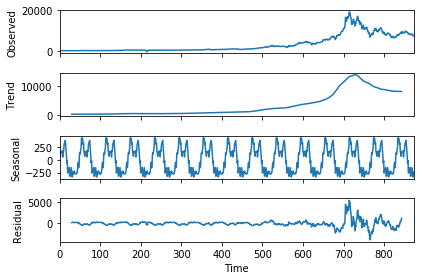

In [10]:
#decomposation with additive model
#We chose `additive`, so add Trend+Seasonal+Residual =`Observed`
s = sm.tsa.seasonal_decompose(working_data2.btc_price.values, freq=60, model = "additive")
splot = s.plot()

In [11]:
#seasonal decomposition using moving average, 60 days frequancy so far
s = sm.tsa.seasonal_decompose(working_data2.btc_price.values, freq=60)


#np.arange: Return evenly spaced values within a given interval.
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(183, 69, 73)'), width = 3))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(244, 122, 244)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(89, 177, 104)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

In [13]:
google = pd.read_csv('google.csv')
bit_spot = pd.read_csv('bit_spot.csv')

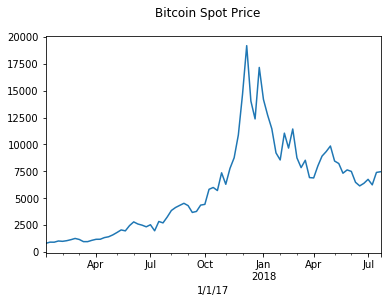

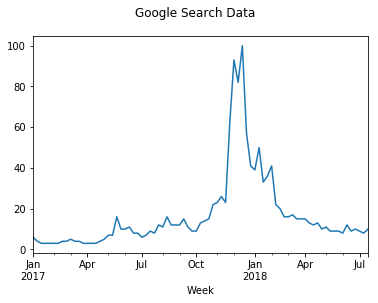

In [14]:
from pandas import Series
fig = plt.figure()
series1 = Series.from_csv('bit_spot.csv', header = 1)
series1.plot()
fig.suptitle('Bitcoin Spot Price')
pyplot.show()

fig = plt.figure()
series2 = Series.from_csv('google.csv', header = 1)
series2.plot()
fig.suptitle('Google Search Data')
pyplot.show()

As we can see from the plots that, there's certain correlation between the bitcoin price movement and the Google search data for Bitcoin. Thus, there is potential we can utilize Google search data by conducting sentiment analysis to forecast the bitcoin price movement. 